In [1]:
from copy import deepcopy
from datetime import datetime, timedelta
from typing import Dict, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.ticker import StrMethodFormatter
from prophet import Prophet

plt.rcParams['figure.figsize'] = 9, 6

In this article we explore an approach to segment-level forecasts (a form of multivariate forecasting) using the top-level series as an extra regressor.

### Dataset for case study - Pedestrian traffic by location

We use the pedestrians dataset from the City of Melbourne, which proxies foot traffic via sensors at various locations in the Melbourne CBD (central business district). We want to predict future foot traffic at key sensor locations; we can think of this as a multivariate forecasting problem, or producing "segment-level" forecasts.

The dataset has been cleaned and aggregated to contain daily counts by location in long form (i.e. one row per day + location), shown below. We have 10 key sensor locations, and the aim is to produce accurate out-of-sample forecasts for each.

In [2]:
peds = pd.read_csv("../examples/example_pedestrians_multivariate.csv", parse_dates=['ds'])

In [3]:
peds

,sensor_id,ds,y,sensor_description
0,1,2010-01-01,14024,Bourke Street Mall (North)
1,1,2010-01-02,18895,Bourke Street Mall (North)
2,1,2010-01-03,14775,Bourke Street Mall (North)
3,1,2010-01-04,21857,Bourke Street Mall (North)
4,1,2010-01-05,20640,Bourke Street Mall (North)
...,...,...,...,...
24626,15,2016-12-27,16790,State Library
24627,15,2016-12-28,17008,State Library
24628,15,2016-12-29,14963,State Library
24629,15,2016-12-30,18702,State Library


In [4]:
segments = peds['sensor_description'].unique()
segments

array(['Bourke Street Mall (North)', 'Bourke Street Mall (South)',
       'Princes Bridge', 'Flinders Street Station Underpass',
       'Webb Bridge', 'Southern Cross Station', 'Waterfront City',
       'New Quay', 'Flagstaff Station', 'State Library'], dtype=object)

In [5]:
peds['ds'].min(), peds['ds'].max()

(Timestamp('2010-01-01 00:00:00'), Timestamp('2016-12-31 00:00:00'))

#### Data prep - filling missing dates

Often, the way we collect data for segment-level forecasts leads to missing dates for certain segments. This can happen as a result of the segment having a zero value for that date, or as a result of a bug in data collection. It's important to distinguish between the two scenarios, otherwise the model training and model evaluation could ignore zero values and hence be biased.

In this dataset, all sensor locations should have non-zero daily counts, so any missing values are likely a result of a physical fault with the sensor or loss of data. This means we do want these values to be `NA` (so they can be excluded from training and validation), and it's good to be explicit about this.

Below we create rows for every day for each segment, and fill the missing values with `np.nan`. 

We'll also rename the column describing the sensor locations to `segment` and use this to label our forecasts.

In [6]:
def clean_data(df: pd.DataFrame, segment_col, missing_fill):
    """
    Ensures each segment has a measurement for each date between the min and max time within the dataframe.

    Fills missing measurements with `fill_value`, which defaults to 0.
    """
    dates = pd.DataFrame({'ds': pd.date_range(start=df['ds'].min(), end=df['ds'].max(), freq='D')})
    segs = pd.DataFrame({'segment': df[segment_col].unique()})
    base_table = pd.merge(dates, segs, how='cross')
    base_table = pd.merge(base_table, df[['ds', segment_col, 'y']].rename(columns={segment_col: 'segment'}), on=['ds', 'segment'], how='left')
    base_table['y'] = base_table['y'].fillna(missing_fill)
    return base_table.sort_values(['segment', 'ds'])

In [7]:
df = clean_data(peds, 'sensor_description', missing_fill=np.nan)

In [8]:
df

,ds,segment,y
0,2010-01-01,Bourke Street Mall (North),14024.0
10,2010-01-02,Bourke Street Mall (North),18895.0
20,2010-01-03,Bourke Street Mall (North),14775.0
30,2010-01-04,Bourke Street Mall (North),21857.0
40,2010-01-05,Bourke Street Mall (North),20640.0
...,...,...,...
25524,2016-12-27,Webb Bridge,2388.0
25534,2016-12-28,Webb Bridge,2841.0
25544,2016-12-29,Webb Bridge,2540.0
25554,2016-12-30,Webb Bridge,3124.0


### Evaluation criteria

To compare the performance of our modelling strategies, we perform 5-fold cross-validation using the latest year in the data (2016) for validation, with validation horizons of 28 days. `SMAPE` will be the evaluation metric for the out-of-sample forecasts.

In [9]:
train_start = datetime(2010, 1, 1)
val_horizon_days = 28
num_vals = 5
val_starts = sorted([datetime(2016, 12, 31) - timedelta(days=val_horizon_days) * i for i in range(1, num_vals + 1)])

In [10]:
def calculate_smape(y: np.array, yhat: np.array) -> float:
    abs_error = np.abs(y - yhat)
    denom = (np.abs(y) + np.abs(yhat)) / 2
    smape = np.nanmean(abs_error / denom)
    return smape

### Prophet configuration

Here we define our Prophet settings. Since the purpose of the exercise is to evaluate the top-level-regressor modelling strategy, we won't change the default values too much. There are a few things we know about the time series that we want to capture though:

* There is day-of-week and month-of-year seasonality in foot traffic (more people in work-related areas on weekdays vs. leisure-related areas on weekends, less people out in the colder months of the year).
* Seasonality is likely multiplicative rather than additive, given the population growth in Melbourne.
* We want to use more of the recent data for estimating the trend, given the population growth in Melbourne.

We'll also be looking at how the different modelling strategies affect the confidence of our predictions, so we modify the `interval_width` to capture a 90% credible interval, and increase the number of uncertainty samples to 5,000 to get more stable lower and upper bound estimates.

For the cross-validation procedure, we define a function that fits up to a certain date in the dataframe history, then predicts on the validation period dates.

In [11]:
model = Prophet(
    changepoint_range=0.95,
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    seasonality_mode='multiplicative',
    interval_width=0.90,
    uncertainty_samples=5000,
)

In [18]:
def train_validate(df: pd.DataFrame, val_start: datetime, val_horizon_days: timedelta, model: Prophet) -> pd.DataFrame:
    val_end = val_start + timedelta(days=val_horizon_days)
    train = df.loc[df['ds'] < val_start]
    val = df.loc[(df['ds'] >= val_start) & (df['ds'] < val_end)]
    model = model.fit(train)
    oos_preds = model.predict(val)
    oos_preds[['yhat_lower', 'yhat', 'yhat_upper']] = oos_preds[['yhat_lower', 'yhat', 'yhat_upper']].clip(lower=0)
    oos_preds['y'] = val['y'].values
    return oos_preds

## Strategy 1: Independent Models

This will be our simple baseline - modelling each segment using only the data in the segment. For each segment, we output the out-of-sample prediction dataframe for each cross-validation fold.

In [19]:
oos_independent = {s: {} for s in segments}
for val_start in val_starts:
    for segment, df_segment in df.groupby('segment'):
        segment_model = deepcopy(model)
        oos_independent[segment][str(val_start)] = train_validate(df_segment, val_start, val_horizon_days, segment_model)

## Strategy 2: Top-level regressor

This is the strategy we're interested in exploring in this tutorial. The strategy is outlined [here](https://github.com/facebook/prophet/issues/49#issuecomment-430383681) by Ben Letham. It involves treating the groups of time series as a hierarchy, with a "top-level" time series that combines them.

The approach involves:

1. Forecasting the top-level series, including any future values.

Note that for cross-validation, we need to use the **forecasted** top-level series values, rather than the true values. This is to prevent information leakage, as the top-level series values would not be known when producing a real forecast.

For the top-level series model, we simply use the same Prophet configurations described in the beginning. This is reasonable, as we would expect the top-level time series to have the same characteristics its constituent segments.

2. Using the historical data from the top-level series, and the future prediction values, as an additional regressor for the time series of each segment.

The Prophet model becomes:

$y_t = (1 + \mathrm{seasonality}_t) * \mathrm{trend}_t + \beta * \mathrm{top level}_t$

Having the top-level series in the model effectively includes information about the growth and seasonality of other segments, which we hypothesize will help produce more accurate segment-level forecasts.

We configure the top-level regressor in the Prophet model as follows:

* The top-level regressor values are standardized.
* We assume the relationship is additive. This is simpler to interpret.
* We use a `prior_scale` of 1.0. This controls the level of regularization on $\beta$; in practice, it represents how much we weight the data and trends in the target segment vs. the data and trends in other segments. For example, if we were confident that a particular segment's trajectory is better determined by its own data (because its growth drivers are very different to that of other segments), we could set a lower prior scale to pull $\beta$ closer to 0.

In [36]:
df_toplevel = df.groupby('ds', as_index=False).agg({'y': 'sum'})

In [37]:
regressor_mode = 'additive'
prior_scale = 1.0
oos_toplevelregr = {s: {} for s in segments}
for val_start in val_starts:
    toplevel_model = deepcopy(model)
    toplevel_history = df_toplevel.loc[df_toplevel['ds'] < val_start]
    toplevel_oos = train_validate(df_toplevel, val_start, val_horizon_days, toplevel_model)
    toplevel = pd.concat([
        toplevel_history[['ds', 'y']].rename(columns={'y': 'top_level'}),
        toplevel_oos[['ds', 'yhat']].rename(columns={'yhat': 'top_level'})
    ], ignore_index=True)
    for segment, df_segment in df.groupby('segment'):
        segment_model = deepcopy(model)
        segment_model.add_regressor('top_level', standardize=True, mode=regressor_mode, prior_scale=prior_scale)
        model_df = pd.merge(df_segment, toplevel, on='ds', how='left')
        model_df['top_level'] = model_df['top_level'].fillna(method='ffill')
        oos_toplevelregr[segment][str(val_start)] = train_validate(model_df, val_start, val_horizon_days, segment_model)

## Comparison

### Visual comparison of out-of-sample predictions

First we'll do a visual comparison of the out-of-sample actuals vs. forecasts under each strategy.

In [38]:
def extract_predictions(
    oos_independent: Dict[str, Dict[str, pd.DataFrame]], 
    oos_toplevelregr: Dict[str, Dict[str, pd.DataFrame]], 
    segment: str
):
    preds_independent = pd.concat(oos_independent[segment], axis=0, names=['val_start']).reset_index()
    preds_toplevelregr = pd.concat(oos_toplevelregr[segment], axis=0, names=['val_start']).reset_index()
    preds = pd.merge(
        preds_independent[['ds', 'y', 'yhat', 'yhat_lower', 'yhat_upper']],
        preds_toplevelregr[['ds', 'yhat', 'yhat_lower', 'yhat_upper']],
        on='ds',
        how='inner',
        suffixes=('_independent', '_toplevelregr')
    )
    return preds

In [39]:
def plot_segment(
    oos_independent: Dict[str, Dict[str, pd.DataFrame]],
    oos_toplevelregr: Dict[str, Dict[str, pd.DataFrame]],
    segment: str,
    ax=None
):
    plot_df = extract_predictions(oos_independent, oos_toplevelregr, segment)
    if ax is None:
        _, ax = plt.subplots()
    ax.plot(plot_df['ds'], plot_df['y'], marker=".", c="black", linestyle="")
    ax.plot(plot_df['ds'], plot_df['yhat_independent'], label='yhat_independent')
    ax.fill_between(x=plot_df['ds'], y1=plot_df['yhat_lower_independent'], y2=plot_df['yhat_upper_independent'], alpha=0.2)
    ax.plot(plot_df['ds'], plot_df['yhat_toplevelregr'], label='yhat_toplevelregr')
    ax.fill_between(x=plot_df['ds'], y1=plot_df['yhat_lower_toplevelregr'], y2=plot_df['yhat_upper_toplevelregr'], alpha=0.2)
    ax.set_title(segment)
    ax.yaxis.set_major_formatter(StrMethodFormatter("{x:,.0f}"))
    ax.legend()
    
    return ax

In [40]:
def plot_all():
    rows, cols = 5, 2
    fig, axs = plt.subplots(
        nrows=rows, 
        ncols=cols, 
        sharex=True, 
        figsize=np.array(plt.rcParams['figure.figsize']) * np.array([cols, rows])
    )
    for segment, ax in zip(segments, axs.flat):
        plot_segment(oos_independent, oos_toplevelregr, segment, ax)
    fig.autofmt_xdate()
    plt.tight_layout()
    
    return fig

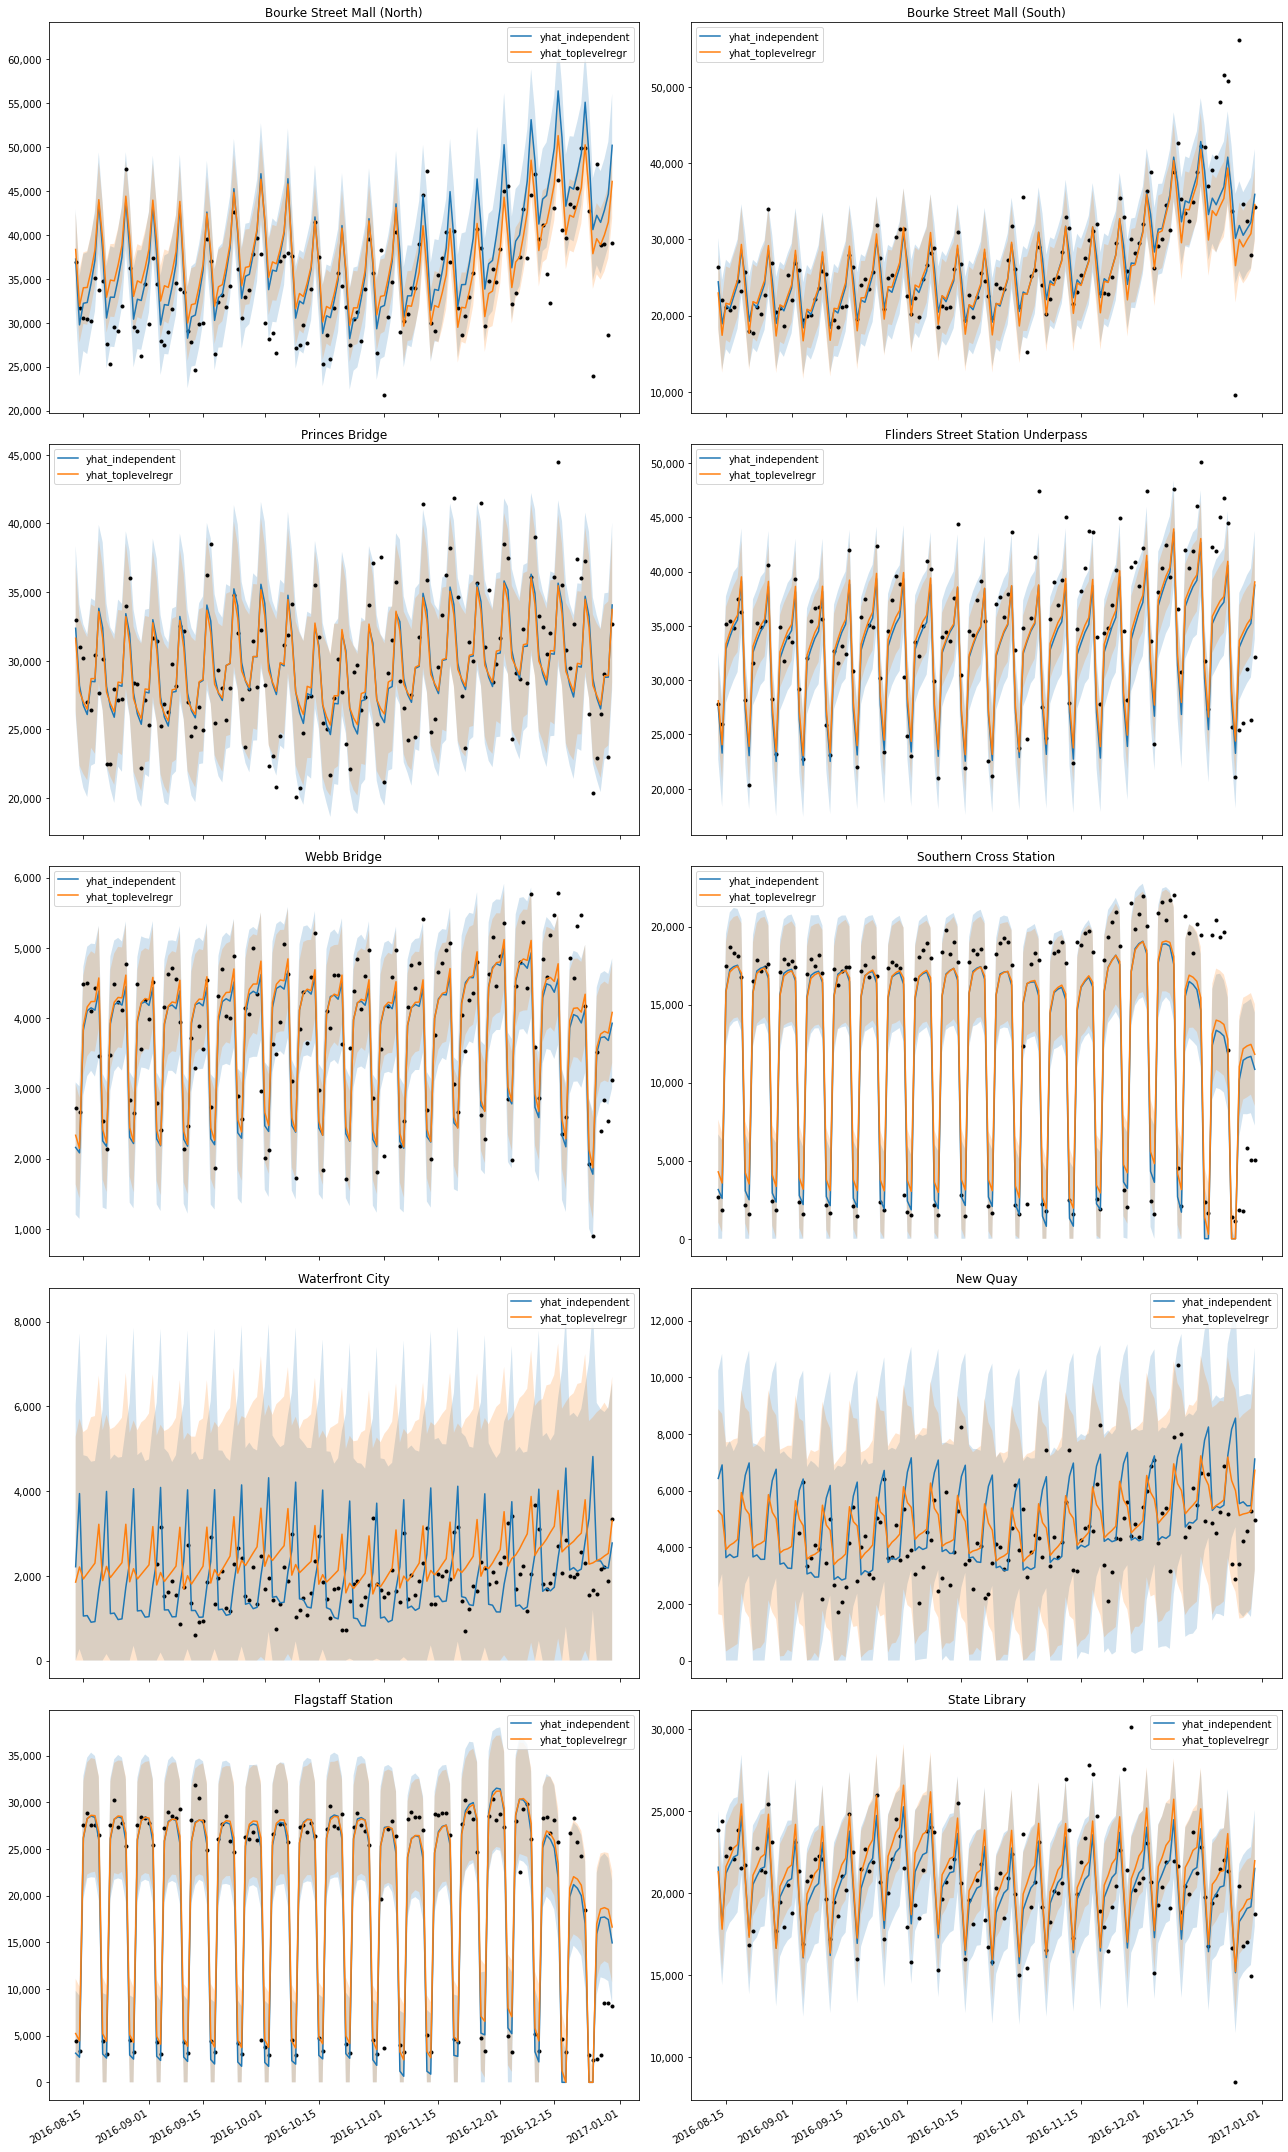

In [41]:
plot_all();

In general, the top-level-regressor strategy forecasts (`yhat`) don't differ too much compared to the independent models strategy. It does, however, seem to provide _less extreme forecasts_, which can be either beneficial or harmful:

* In the `Bourke Street Mall (North)` segment, the independent model captures an increased growth starting in November, and slightly overforecasts the future. The model with the top-level-regressor does not overforecast, likely reflecting the lower "average" growth across all the segments.
* The `Southern Cross Station` and `Flagstaff Station` segments exhibit strong negative weekend effects, which are **not** picked up well by the top-level-regressor strategy. The top-level-regressor strategy overpredicts weekends, likely because the seasonality effect is not as strong in the other segments.
* The `Waterfront City` and `New Quay` segments are not forecasted by either strategy, due to their low volume and fairly irregular pattern. The top-level-regressor strategy produces forecasts with weaker seasonality effects, which seems to be beneficial for `New Quay` but not `Waterfront City`.

Given the mixed performance of the top-level-regressor strategy, we should keep in mind the following when using it for segment-level forecasts:

1. Performing cross-validation to compare the top-level-regressor strategy to the independent model strategy is important. The top-level-regressor strategy is most useful for pulling the forecast of the target segment back to an "average level" of growth, i.e. producing less extreme forecasts. We shouldn't expect it to automatically provide more accurate forecasts.
1. Choice of `prior_scale` is important and should be chosen explicitly for each segment being forecasted. This controls the weight the model places on the data and trends in the other segments. For example, a lower `prior_scale` places less weight on the other segments, which makes sense when the target segment has unique underlying growth drivers.
1. Adding the top-level series as a regressor can lead to less accurate seasonality fits. To prevent this, we could choose segments that exhibit similar seasonal patterns to include in the top-level series, and exclude others.

### `SMAPE` comparisons

We've seen above that the top-level-regressor strategy gives mixed results depending on the segment being forecasted. We now summarise the `SMAPE` values for the out-of-sample forecasts for each segment. Note that a lower `SMAPE` implies a more accurate forecast.

In [52]:
def summarise_smape(
    oos_independent: Dict[str, Dict[str, pd.DataFrame]], 
    oos_toplevelregr: Dict[str, Dict[str, pd.DataFrame]], 
):
    smape_summ = []
    for segment in segments:
        preds = extract_predictions(oos_independent, oos_toplevelregr, segment)
        smape_i = calculate_smape(preds['y'], preds['yhat_independent'])
        smape_tlr = calculate_smape(preds['y'], preds['yhat_toplevelregr'])
        smape_summ.append(pd.DataFrame([[segment, smape_i, smape_tlr]], columns=['segment', 'smape_independent', 'smape_toplevelregr'], index=[0]))
    smape_summ = pd.concat(smape_summ, ignore_index=True).set_index('segment')
    smape_summ['diff_toplevelregr'] = smape_summ['smape_toplevelregr'] - smape_summ['smape_independent']
    return smape_summ

In [53]:
smape_summary = summarise_smape(oos_independent, oos_toplevelregr)

In [54]:
smape_summary.style.format("{:.2%}")

,smape_independent,smape_toplevelregr,diff_toplevelregr
segment,,,
Bourke Street Mall (North),11.05%,11.32%,0.27%
Bourke Street Mall (South),8.91%,10.30%,1.39%
Princes Bridge,9.84%,9.86%,0.02%
Flinders Street Station Underpass,9.15%,8.54%,-0.62%
Webb Bridge,13.32%,13.02%,-0.30%
Southern Cross Station,26.34%,30.36%,4.01%
Waterfront City,33.79%,37.13%,3.34%
New Quay,24.67%,23.45%,-1.22%
Flagstaff Station,28.09%,20.35%,-7.73%


The top-level-regressor strategy produces:

* In **2 out of 10** segments, an SMAPE _improvement_ of >1% absolute.
* In **4 out of 10** segments forecasted, an SMAPE _deterioration_ of >1% absolute.
* In **4 out of 10** segments, no material change in SMAPE (between -1% and 1% absolute impact).

### Uncertainty interval comparisons 

One thing we haven't touched on is the uncertainty intervals produced with the top-level-regressor strategy. Notice that the intervals are generally tighter compared to that of the independent models, but this is **not** representative of the actual uncertainty because:

* We haven't performed MCMC sampling for the distribution of the $\beta$ coefficient. We assume it takes the mean the value for all future predictions, but the ideally we account for the range of possible values $\beta$ could take.
* We haven't factored in the uncertainty in the forecast of the top-level series. We use the `yhat` of the top-level series in our target segment prediction, which doesn't capture the potential variation in the top-level series forecast.

For this reason, the tighter intervals may not accurately capture the range of possible outcomes. We check this below by calculating the size of the 90% uncertainty interval, and the proportion of actual `y` values that lie within the interval, across the two strategies.

In [55]:
def summarise_uncertainty(
    oos_independent: Dict[str, Dict[str, pd.DataFrame]], 
    oos_toplevelregr: Dict[str, Dict[str, pd.DataFrame]], 
):
    uncertainty = []
    for segment in segments:
        preds = extract_predictions(oos_independent, oos_toplevelregr, segment)
        interval_size_i = np.mean(preds['yhat_upper_independent'] - preds['yhat_lower_independent'])
        interval_size_tlr = np.mean(preds['yhat_upper_toplevelregr'] - preds['yhat_lower_toplevelregr'])
        perc_within_i = np.mean((preds['y'] > preds['yhat_lower_independent']) & (preds['y'] < preds['yhat_upper_independent']))
        perc_within_tlr = np.mean((preds['y'] > preds['yhat_lower_toplevelregr']) & (preds['y'] < preds['yhat_upper_toplevelregr']))
        uncertainty.append(
            pd.DataFrame(
                [[segment, interval_size_i, interval_size_tlr, perc_within_i, perc_within_tlr]], 
                columns=['segment', 'interval_size_independent', 'interval_size_toplevelregr', 'perc_within_independent', 'perc_within_toplevelregr'], 
                index=[0]
            )
        )
    uncertainty = pd.concat(uncertainty, ignore_index=True).set_index('segment')
    uncertainty['interval_size_diff'] = uncertainty['interval_size_toplevelregr'] - uncertainty['interval_size_independent']
    uncertainty['perc_within_diff'] = uncertainty['perc_within_toplevelregr'] - uncertainty['perc_within_independent']
    return uncertainty

In [56]:
uncertainty = summarise_uncertainty(oos_independent, oos_toplevelregr)

In [57]:
uncertainty[[c for c in uncertainty.columns if c.startswith('interval_size')]].style.format("{:,.0f}")

,interval_size_independent,interval_size_toplevelregr,interval_size_diff
segment,,,
Bourke Street Mall (North),"11,577","8,255","-3,321"
Bourke Street Mall (South),"11,804","9,723","-2,080"
Princes Bridge,"12,001","10,465","-1,536"
Flinders Street Station Underpass,"9,805","6,751","-3,054"
Webb Bridge,"1,854","1,419",-435
Southern Cross Station,"6,729","6,325",-404
Waterfront City,"5,639","5,848",209
New Quay,"7,611","7,186",-425
Flagstaff Station,"11,799","11,343",-456


In [58]:
uncertainty[[c for c in uncertainty.columns if c.startswith('perc_within')]].style.format("{:.2%}")

,perc_within_independent,perc_within_toplevelregr,perc_within_diff
segment,,,
Bourke Street Mall (North),76.43%,57.86%,-18.57%
Bourke Street Mall (South),94.29%,85.71%,-8.57%
Princes Bridge,88.57%,81.43%,-7.14%
Flinders Street Station Underpass,76.43%,66.43%,-10.00%
Webb Bridge,90.71%,84.29%,-6.43%
Southern Cross Station,85.71%,86.43%,0.71%
Waterfront City,85.00%,85.00%,0.00%
New Quay,82.86%,84.29%,1.43%
Flagstaff Station,91.43%,92.14%,0.71%


* We can see that in the segments where the size of the uncertainty interval reduced the most, we also saw a much lower proportion of `y` values (actual traffic counts) fall within the uncertainty interval. 
* There are some instances (4 out of 10 segments) where the proportion of `y` values within the interval slightly improves when using the top-level regressor strategy, but in these instances the interval size is roughly the same as under the independent-model strategy.

These results reinforce that if we want reliable uncertainty estimates when using the top-level-regressor strategy, we need to perform full MCMC sampling for $\beta$ and account for the uncertainty of the top-level forecast.

## Further reading

We've walked through one strategy for producing segment-level forecasts with Prophet. Other modelling strategies for this use case include:

* Estimating the model parameters for each segment simultaeneously using partial pooling, as described [here](https://github.com/facebook/prophet/issues/49#issuecomment-283254534).
* [Vector Autoregressive (VAR) models](https://otexts.com/fpp3/VAR.html).
* [Forecast reconciliation for hierarchical forecasts](https://otexts.com/fpp3/hierarchical.html).

As with the top-level-regressor strategy, these strategies make assumptions about the data generation process and the relationship between the different segments, and it's recommended to outline a validation scheme (e.g. cross-validation) to assess their suitability for the task at hand.